<a href="https://colab.research.google.com/github/sergioglezsuarez/sergioglezsuarez/blob/main/Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import pandas as pd
import shutil
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from google.colab import drive

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # oculta muchos mensajes de tensorflow

In [2]:
class LRA(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, factor, batches, epochs, ask_epoch, threshold):
        super(LRA, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience  # cuántos epochs sin mejora hasta ajustar learning rate
        self.stop_patience = stop_patience  # cuántas veces se ajusta learning rate antes de parar el entrenamiento
        self.factor = factor  # cuánto se reduce learning rate
        self.batches = batches  # número de lotes por epoch
        self.threshold = threshold  # umbral mínimo de tr_acc
        self.epochs = epochs  # número de epochs
        self.ask_epoch = ask_epoch  # epoch en la que se pregunta si se quiere parar el entrenamiento
        self.count = 0  # cuántos epochs no ha habido mejora
        self.stop_count = 0  # cuántas veces se ha ajustado learning rate sin mejora
        self.best_epoch = 1  # mejor epoch
        self.highest_tr_acc = 0.0  # mayor training accuracy
        self.lowest_val_loss = np.inf  # menor validation loss
        self.best_weights = self.model.get_weights()  # mejores pesos
        self.initial_weights = self.model.get_weights()  # pesos iniciales

    def on_train_begin(self, logs=None):
        print('{0:^8s}{1:^10s}{2:^10s}{3:^10s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}'.format('Epoch', 'Tr loss',
                                                                                           'Tr acc',
                                                                                           'Val loss', 'Val acc', 'LR',
                                                                                           'Sig LR', 'Monitor',
                                                                                           'Mejora (%)'))

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)  # cuando acaba el entrenamiento se guardan los mejores pesos
        print(f'Entrenamiento completado. El modelo tiene los pesos del epoch {self.best_epoch}')

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        val_loss = logs.get('val_loss')
        tr_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        if tr_acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                improve = 0.0
            else:
                improve = (tr_acc - self.highest_tr_acc) * 100 / self.highest_tr_acc
            if tr_acc > self.highest_tr_acc:
                self.highest_tr_acc = tr_acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    self.model.set_weights(self.best_weights)
                else:
                    self.count = self.count + 1
        else:
            monitor = 'val_loss'
            if epoch == 0:
                improve = 0.0
            else:
                improve = (self.lowest_val_loss - val_loss) * 100 / self.lowest_val_loss
            if val_loss < self.lowest_val_loss:
                self.lowest_val_loss = val_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.model.set_weights(self.best_weights)
                else:
                    self.count = self.count + 1
        
        print(f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{tr_acc:^9.3f}{val_loss:^9.5f}{val_acc:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{improve:^10.2f}')
        
        if self.stop_count > self.stop_patience - 1:
            print(f'El entrenamiento ha sido parado en el epoch {epoch + 1} después de {self.stop_patience} ajustes del learning rate sin mejora.')
            self.model.stop_training = True
        else:
            if self.ask_epoch is not None:
                if epoch + 1 >= self.ask_epoch:
                    print('Introducir P para parar el entrenamiento o el número de epochs más que se quiere que continúe el entrenamiento')
                    ans = input()
                    if ans == 'P' or ans == 'p':
                        print(f'El entrenamiento ha sido parado en el epoch {epoch + 1}')
                        self.model.stop_training = True
                    else:
                        ans = int(ans)
                        self.ask_epoch += ans
                        print(f'El entrenamiento continuará hasta el epoch {self.ask_epoch}')
                        print('{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}'.format('Epoch',
                                                                                                         'Tr loss',
                                                                                                         'Tr acc',
                                                                                                         'Val loss',
                                                                                                         'Val acc',
                                                                                                         'LR',
                                                                                                         'Sig LR',
                                                                                                         'Monitor',
                                                                                                         'Mejora (%)'))


In [3]:
def plot(tr_data):
    tr_acc = tr_data.history['accuracy']
    tr_loss = tr_data.history['loss']
    val_acc = tr_data.history['val_accuracy']
    val_loss = tr_data.history['val_loss']
    epoch_count = len(tr_acc)
    epochs = []
    for i in range(epoch_count):
        epochs.append(i + 1)
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'mejor epoch: ' + str(index_loss + 1)
    vc_label = 'mejor epoch: ' + str(index_acc + 1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(epochs, tr_loss, 'r', label='Training loss')
    axes[0].plot(epochs, val_loss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training y Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(epochs, tr_acc, 'r', label='Training Accuracy')
    axes[1].plot(epochs, val_acc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training y Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.show()


In [4]:
def trim(df, size, column):
    df = df.copy()
    class_count = len(list(df[column].unique()))
    print(f'Número de clases en el dataframe: {class_count}\n')
    print(f'Número de imágenes por clase en el dataframe de entrenamiento:')
    print(list(df[column].value_counts()))
    sample_list = []
    groups = df.groupby(column)
    for label in df[column].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count > size:
            strat = group[column]
            samples, _ = train_test_split(group, train_size=size, shuffle=True, random_state=123, stratify=strat)
            sample_list.append(samples)
        else:
            sample_list.append(group)
    df = pd.concat(sample_list, axis=0).reset_index(drop=True)
    print('Número de imágenes por clase en el dataframe de entrenamiento reducido:')
    print(list(df[column].value_counts()))
    return df


In [5]:
def balance(train_df, samples, column, working_dir, image_size):
    # train_df = train_df.copy()
    train_df = trim(train_df, samples, column)
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    total = 0
    generator = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2,
                             height_shift_range=.2, zoom_range=.2)
    groups = train_df.groupby('labels')
    for label in train_df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < samples:
            aug_img_count = 0
            n = samples - sample_count
            dir = os.path.join(aug_dir, label)
            aug_gen = generator.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=image_size,
                                              class_mode=None, batch_size=1, shuffle=False,
                                              save_to_dir=dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            while aug_img_count < n:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
    print(f'\nNúmero total de imágenes aumentadas: {total}\n')

    if total > 0:
        aug_fpaths = []
        aug_labels = []
        classlist = os.listdir(aug_dir)
        for klass in classlist:
            classpath = os.path.join(aug_dir, klass)
            flist = os.listdir(classpath)
            for f in flist:
                fpath = os.path.join(classpath, f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        fseries = pd.Series(aug_fpaths, name='filepaths')
        lseries = pd.Series(aug_labels, name='labels')
        aug_df = pd.concat([fseries, lseries], axis=1)
        train_df = pd.concat([train_df, aug_df], axis=0).reset_index(drop=True)

    print('Número final de imágenes por clase:')
    print(list(train_df['labels'].value_counts()))
    return train_df


In [6]:
def preprocess(dir):
    categories = ['train', 'test', 'valid']
    for category in categories:
        cat_path = os.path.join(dir, category)
        filepaths = []
        labels = []
        classlist = os.listdir(cat_path)
        for klass in classlist:
            classpath = os.path.join(cat_path, klass)
            flist = os.listdir(classpath)
            for f in flist:
                fpath = os.path.join(classpath, f)
                filepaths.append(fpath)
                labels.append(klass)
        fseries = pd.Series(filepaths, name='filepaths')
        lseries = pd.Series(labels, name='labels')
        if category == 'train':
            train_df = pd.concat([fseries, lseries], axis=1)
        elif category == 'test':
            test_df = pd.concat([fseries, lseries], axis=1)
        else:
            val_df = pd.concat([fseries, lseries], axis=1)
    print(f'Longitud del dataframe de entrenamiento: {len(train_df)}')
    print(f'Longitud del dataframe de test: {len(test_df)}')
    print(f'Longitud del dataframe de validación: {len(val_df)}')
    return train_df, test_df, val_df


Mounted at /content/drive
Image shape: (224, 224, 3)


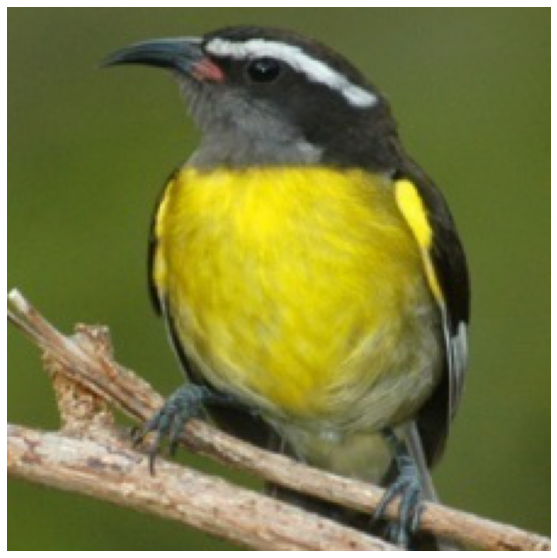

In [7]:
drive.mount('/content/drive')
img_path = r'/content/drive/MyDrive/clases uni/dataset10/train/BANANAQUIT/044.jpg'
plt.figure(figsize=(10, 10))
img = plt.imread(img_path)
print(f'Image shape: {img.shape}')
plt.axis('off')
imshow(img)

In [8]:
dir = r'/content/drive/MyDrive/clases uni/dataset10/'
train_df, test_df, valid_df = preprocess(dir)

Longitud del dataframe de entrenamiento: 1543
Longitud del dataframe de test: 50
Longitud del dataframe de validación: 50


In [9]:
samples = 140
column = 'labels'
working_dir = r'/content/drive/MyDrive/clases uni/'
img_size = (150, 150)
print('Ajustando el dataframe de entrenamiento:')
print('----------------------------------------')
train_df = balance(train_df, samples, column, working_dir, img_size)

Ajustando el dataframe de entrenamiento:
----------------------------------------
Número de clases en el dataframe: 10

Número de imágenes por clase en el dataframe de entrenamiento:
[233, 175, 166, 160, 157, 149, 137, 126, 120, 120]
Número de imágenes por clase en el dataframe de entrenamiento reducido:
[140, 140, 140, 140, 140, 140, 137, 126, 120, 120]
Found 126 validated image filenames.
Found 120 validated image filenames.
Found 137 validated image filenames.
Found 120 validated image filenames.

Número total de imágenes aumentadas: 57

Número final de imágenes por clase:
[140, 140, 140, 140, 140, 140, 140, 140, 140, 140]


In [10]:
batch_size = 40
img_shape = (150, 150, 3)
test_batch_size = 50
test_steps = 1

In [11]:
def scalar(img):
    return img  # Necesitamos una función para aplicársela a cada imagen. Usamos una que devuelve la misma imagen.


In [12]:
tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
test_val_gen = ImageDataGenerator(preprocessing_function=scalar)
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = test_val_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                     class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen = test_val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 1400 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.


In [13]:
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
batches = int(np.ceil(len(train_gen.labels) / batch_size))
epochs = 40
patience = 1
stop_patience = 3
factor = .5
ask_epoch = 10
initial_lr = .001
threshold = .99

print('Empezando el entrenamiento:')
print(f'Número de lotes: {batches} - Tamaño de lote: {batch_size}')
print(f'Número de epochs: {epochs}')
print(f'Learning rate inicial: {initial_lr} - Factor de ajuste del learning rate: {factor}')

model_name = 'modelo'
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape,
                                                  pooling='max')
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [LRA(model=model, base_model=base_model, batches=batches, epochs=epochs, patience=patience,
                 stop_patience=stop_patience, factor=factor, ask_epoch=ask_epoch, threshold=threshold)]

history = model.fit(x=train_gen, epochs=epochs, verbose=0, callbacks=callbacks, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, initial_epoch=0)

Empezando el entrenamiento:
Número de lotes: 35 - Tamaño de lote: 40
Número de epochs: 40
Learning rate inicial: 0.001 - Factor de ajuste del learning rate: 0.5
43950080/43941136 [==============================] - 0s 0us/step
 Epoch   Tr loss    Tr acc   Val loss  Val acc    LR     Sig LR   Monitor  Mejora (%)
 1 /40     8.486    0.712   8.24716   0.900   0.00100  0.00100  accuracy     0.00   
 2 /40     6.952    0.951   6.66837   0.920   0.00100  0.00100  accuracy    33.50   
 3 /40     6.118    0.979   5.81338   0.940   0.00100  0.00100  accuracy     3.01   
 4 /40     5.420    0.979   5.10565   0.960   0.00100  0.00050  accuracy     0.00   
 5 /40     5.575    0.985   5.39113   0.960   0.00050  0.00050  accuracy     0.58   
 6 /40     5.210    0.996   5.02793   0.980   0.00050  0.00050  val_loss     nan    
 7 /40     4.895    0.996   4.70670   0.980   0.00050  0.00050  val_loss     6.39   
 8 /40     4.587    0.997   4.41133   1.000   0.00050  0.00050  val_loss     6.28   
 9 /40  

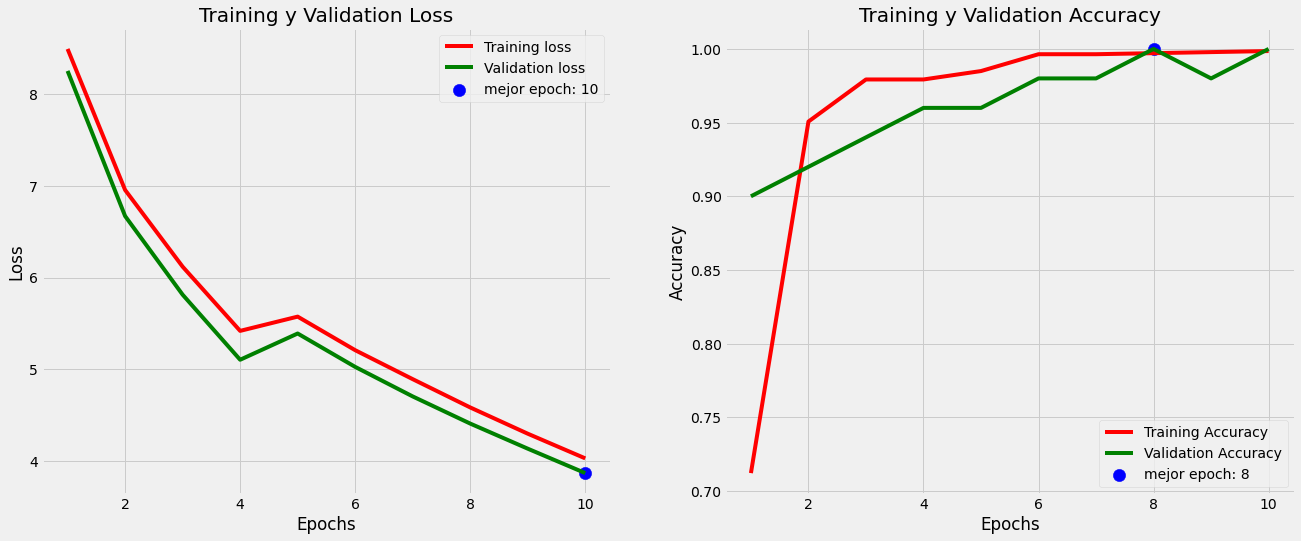

1/1 [==============================] - 3s 3s/step - loss: 3.8770 - accuracy: 1.0000
Test accuracy: 100.00%


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [14]:
plot(history)
tr_acc = model.evaluate(test_gen, verbose=1, steps=test_steps, return_dict=False)[1] * 100
print(f'Test accuracy: {tr_acc:5.2f}%')
generator = train_gen
save_path = r'./'
save_id = str(model_name + '-' + str(tr_acc)[:str(tr_acc).rfind('.')] + '-' + str(initial_lr) + '.h5')
model.save(os.path.join(save_path, save_id))

In [15]:
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
batches = int(np.ceil(len(train_gen.labels) / batch_size))
epochs = 40
patience = 1
stop_patience = 3
factor = .5
ask_epoch = 10
initial_lr = .01
threshold = .99

print('Empezando el entrenamiento:')
print(f'Número de lotes: {batches} - Tamaño de lote: {batch_size}')
print(f'Número de epochs: {epochs}')
print(f'Learning rate inicial: {initial_lr} - Factor de ajuste del learning rate: {factor}')

model_name = 'modelo'
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape,
                                                  pooling='max')
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [LRA(model=model, base_model=base_model, batches=batches, epochs=epochs, patience=patience,
                 stop_patience=stop_patience, factor=factor, ask_epoch=ask_epoch, threshold=threshold)]

history = model.fit(x=train_gen, epochs=epochs, verbose=0, callbacks=callbacks, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, initial_epoch=0)

Empezando el entrenamiento:
Número de lotes: 35 - Tamaño de lote: 40
Número de epochs: 40
Learning rate inicial: 0.01 - Factor de ajuste del learning rate: 0.5
 Epoch   Tr loss    Tr acc   Val loss  Val acc    LR     Sig LR   Monitor  Mejora (%)
 1 /40    11.883    0.350  138770304.00000  0.100   0.01000  0.01000  accuracy     0.00   
 2 /40     6.765    0.491  3273214.75000  0.100   0.01000  0.01000  accuracy    40.20   
 3 /40     3.787    0.696  37594.21094  0.100   0.01000  0.01000  accuracy    41.78   
 4 /40     2.459    0.772  85.88887   0.460   0.01000  0.01000  accuracy    10.99   
 5 /40     1.605    0.838   3.87553   0.740   0.01000  0.01000  accuracy     8.51   
 6 /40     1.214    0.870   2.93197   0.820   0.01000  0.01000  accuracy     3.84   
 7 /40     1.023    0.889   2.52390   0.840   0.01000  0.01000  accuracy     2.13   
 8 /40     0.904    0.894   1.27754   0.840   0.01000  0.01000  accuracy     0.64   
 9 /40     0.757    0.931   0.67989   0.960   0.01000  0.01000

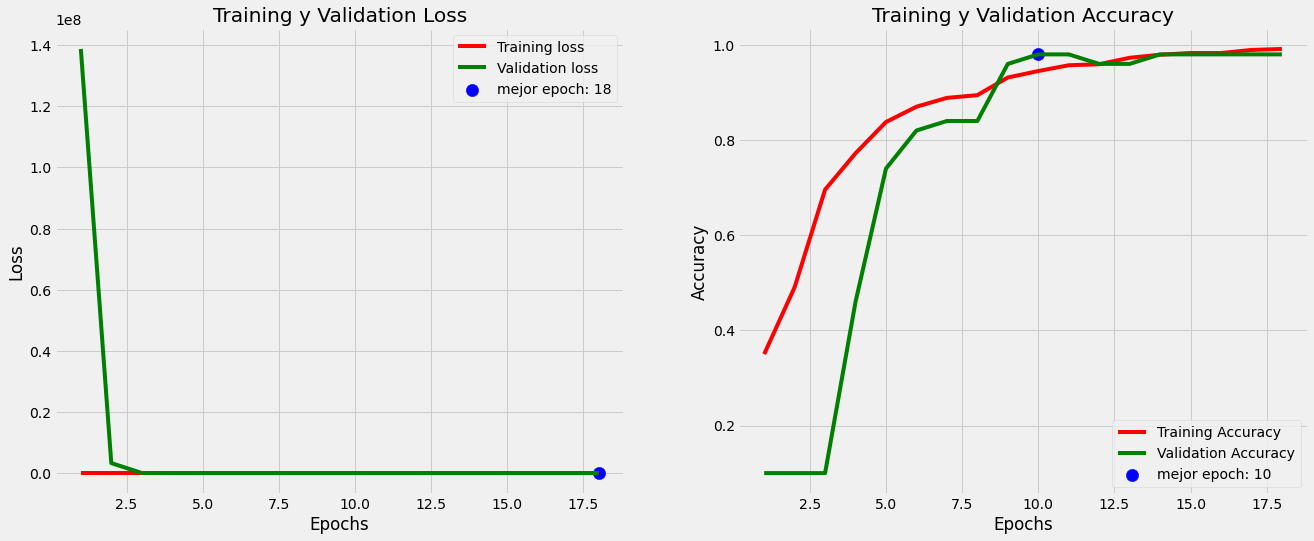

1/1 [==============================] - 3s 3s/step - loss: 0.2968 - accuracy: 1.0000
Test accuracy: 100.00%


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [16]:
plot(history)
tr_acc = model.evaluate(test_gen, verbose=1, steps=test_steps, return_dict=False)[1] * 100
print(f'Test accuracy: {tr_acc:5.2f}%')
generator = train_gen
save_path = r'./'
save_id = str(model_name + '-' + str(tr_acc)[:str(tr_acc).rfind('.')] + '-' + str(initial_lr) + '.h5')
model.save(os.path.join(save_path, save_id))

In [17]:
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
batches = int(np.ceil(len(train_gen.labels) / batch_size))
epochs = 40
patience = 1
stop_patience = 3
factor = .5
ask_epoch = 10
initial_lr = .0001
threshold = .99

print('Empezando el entrenamiento:')
print(f'Número de lotes: {batches} - Tamaño de lote: {batch_size}')
print(f'Número de epochs: {epochs}')
print(f'Learning rate inicial: {initial_lr} - Factor de ajuste del learning rate: {factor}')

model_name = 'modelo'
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape,
                                                  pooling='max')
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.45, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [LRA(model=model, base_model=base_model, batches=batches, epochs=epochs, patience=patience,
                 stop_patience=stop_patience, factor=factor, ask_epoch=ask_epoch, threshold=threshold)]

history = model.fit(x=train_gen, epochs=epochs, verbose=0, callbacks=callbacks, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, initial_epoch=0)

Empezando el entrenamiento:
Número de lotes: 35 - Tamaño de lote: 40
Número de epochs: 40
Learning rate inicial: 0.0001 - Factor de ajuste del learning rate: 0.5
 Epoch   Tr loss    Tr acc   Val loss  Val acc    LR     Sig LR   Monitor  Mejora (%)
 1 /40    10.598    0.186   9.83189   0.360   0.00010  0.00010  accuracy     0.00   
 2 /40     9.598    0.405   8.81690   0.720   0.00010  0.00010  accuracy    117.24  
 3 /40     9.000    0.559   8.34941   0.840   0.00010  0.00010  accuracy    38.10   
 4 /40     8.592    0.686   8.12022   0.920   0.00010  0.00010  accuracy    22.73   
 5 /40     8.328    0.784   7.94461   0.920   0.00010  0.00010  accuracy    14.26   
 6 /40     8.126    0.825   7.80396   0.940   0.00010  0.00010  accuracy     5.19   
 7 /40     7.967    0.861   7.71154   0.960   0.00010  0.00010  accuracy     4.42   
 8 /40     7.837    0.888   7.63729   0.960   0.00010  0.00010  accuracy     3.07   
 9 /40     7.744    0.899   7.56894   0.960   0.00010  0.00010  accuracy

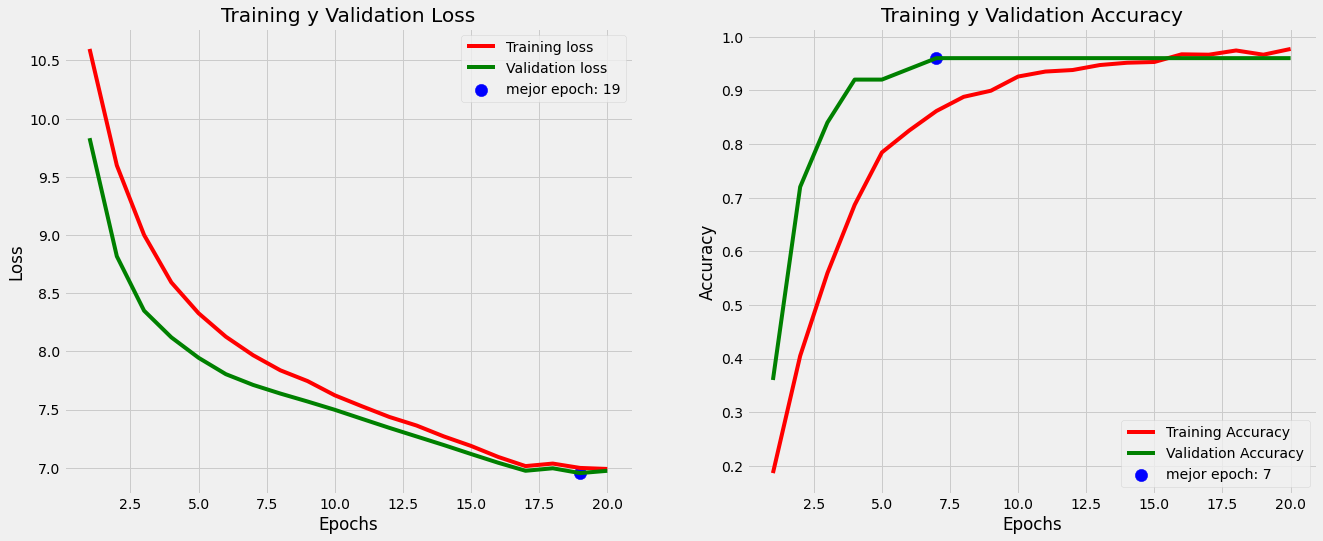

1/1 [==============================] - 3s 3s/step - loss: 6.9307 - accuracy: 0.9800
Test accuracy: 98.00%


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [18]:
plot(history)
tr_acc = model.evaluate(test_gen, verbose=1, steps=test_steps, return_dict=False)[1] * 100
print(f'Test accuracy: {tr_acc:5.2f}%')
generator = train_gen
save_path = r'./'
save_id = str(model_name + '-' + str(tr_acc)[:str(tr_acc).rfind('.')] + '-' + str(initial_lr) + '.h5')
model.save(os.path.join(save_path, save_id))

In [19]:
preds = model.predict(test_gen, steps=test_steps, verbose=1)

1/1 [==============================] - 6s 6s/step


El modelo predice que la imagen pertenece a la clase BANANAQUIT con una probabilidad de 99.79363679885864


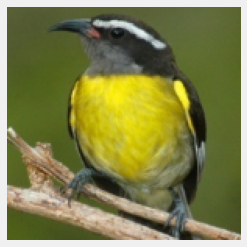

In [21]:
fpath = r'/content/drive/MyDrive/clases uni/dataset10/train/BANANAQUIT/044.jpg'
img = plt.imread(fpath)
img = cv2.resize(img, img_size)
plt.axis('off')
plt.imshow(img)
# Normally the next line of code rescales the images. However the EfficientNet model expects images in the range 0 to 255
# img= img/255
# plt.imread returns a numpy array so it is not necessary to convert the image to a numpy array
# since we have only one image we have to expand the dimensions of img so it is off the form (1,224,224,3)
# where the first dimension 1 is the batch size used by model.predict
img = np.expand_dims(img, axis=0)
pred = model.predict(img)
index = np.argmax(pred[0])
klass = classes[index]
probability = pred[0][index] * 100
print(f'El modelo predice que la imagen pertenece a la clase {klass} con una probabilidad de {probability}')

In [22]:
dir_path = r'/content/drive/MyDrive/clases uni/dataset10/test/BOBOLINK'
images = []
file_list = os.listdir(dir_path)
for f in file_list:
    fpath = os.path.join(dir_path, f)
    img = plt.imread(fpath)
    img = cv2.resize(img, img_size)
    images.append(img)
img_array = np.array(images)
preds = model.predict(img_array)
print(f'Las probabilidades de las predicciones son: {preds.shape}')
f = 'FILE'
c = 'CLASS'
p = 'PROBABILITY'
print(f'{f:^10s} {c:^35s} {p:^10s}')
for i, prob in enumerate(preds):
    index = np.argmax(prob)
    klass = classes[index]
    probability = prob[index] * 100
    file = file_list[i]
    print(f'{file:^10s}{klass:^35s}  {probability:^10.2f}')

Las probabilidades de las predicciones son: (5, 10)
   FILE                   CLASS                PROBABILITY
  3.jpg                BOBOLINK                  99.19   
  5.jpg                BOBOLINK                  93.08   
  2.jpg                BOBOLINK                  96.56   
  1.jpg                BOBOLINK                  52.55   
  4.jpg                BOBOLINK                  99.68   
